## Initial Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Load CSV


In [36]:
# Load the labeled data
df = pd.read_csv('RLHF_labeled_final.csv')

# Basic info
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
# df["Job_Description"][:3]

Dataset shape: (2810, 4)

Columns: ['Label', 'Job_Title', 'Job_Description', 'Index']

First few rows:


## Convert the Label to 1s and 0s: 1=True, 0=False

In [5]:
## Other way: df['Label'] = (df['Label'] == 1).astype(int)
df['Label'] = df['Label'].apply(lambda x: 1 if x==1 else 0 )


## Cleaning of Job Descriptions


In [6]:
import re

def clean_text_for_classification(text, is_title = False):
  """
  Cleaning preserving keywords and removing noise.
  """

  if pd.isna(text):
    return("")

  text = str(text)

  # Remove common prefixes
  if not is_title:
    text = re.sub(r'^About the job\s*', '', text, flags = re.IGNORECASE) # \s* is 0 or + whitespaces (tabs, spaces, newlines)
    text = re.sub(r'^Job Description\s*', '', text, flags=re.IGNORECASE)


  # Normalize whitespace (including spaces, newlines, tabs)
  text = re.sub(r'\s+', ' ', text) # replace 1 or more spaces with just ' '

  # Remove excessive punctuation but keeping structure
  text = re.sub(r'([.!?¿])\1+', r'\1', text)
  text = re.sub(r'[-=_]{3,}', ' ', text)

  # Remove bullet points but keep the text
  text = re.sub(r'^\s*[•·▪▫◆◇○●\-\*]\s*', '', text, flags=re.MULTILINE)
  text = re.sub(r'^\s*\d+[\.\)]\s*', '', text, flags=re.MULTILINE)

  # Remove extra spaces
  text = ' '.join(text.split())

  return text.strip()

df['Job_Title_Clean'] = df['Job_Title'].apply(lambda x: clean_text_for_classification(x, is_title=True))
df['Job_Description_Clean'] = df['Job_Description'].apply(lambda x: clean_text_for_classification(x, is_title=False))


# Handle missing values
df['Job_Description_Clean'] = df['Job_Description_Clean'].fillna('')

# Calculate text lengths
df['title_len'] = df['Job_Title_Clean'].str.len()
df['desc_len'] = df['Job_Description_Clean'].str.len()



In [7]:
# Check the results
print("Cleaning Results:")
print(f"Total rows: {len(df)}")
print(f"Empty titles: {(df['title_len'] == 0).sum()}")
print(f"Empty descriptions: {(df['desc_len'] == 0).sum()}")
print(f"\nDescription lengths:")
print(df['desc_len'].describe())

# Show some examples
print("\n" + "="*50)
print("Sample cleaned data:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Title: {df.iloc[i]['Job_Title_Clean']}")
    # print(f"Description (first 300 chars): {df.iloc[i]['Job_Description_Clean'][:300]}...")
    print(f"Label: {df.iloc[i]['Label']}")


Cleaning Results:
Total rows: 2810
Empty titles: 0
Empty descriptions: 11

Description lengths:
count     2810.000000
mean      2430.459075
std       1571.390425
min          0.000000
25%       1264.500000
50%       2118.000000
75%       3176.000000
max      12493.000000
Name: desc_len, dtype: float64

Sample cleaned data:

Example 1:
Title: Applied AI Engineer
Label: 1

Example 2:
Title: Data Scientist
Label: 0

Example 3:
Title: Senior GenAI Engineer
Label: 1


In [8]:
# Remove rows with very short or empty descriptions
MIN_DESC_LENGTH = 50  # Reasonable minimum for a job description

print(f"Rows with description < {MIN_DESC_LENGTH} chars: {(df['desc_len'] < MIN_DESC_LENGTH).sum()}")

# Keep only valid rows
df_clean = df[df['desc_len'] >= MIN_DESC_LENGTH].copy()

print(f"\nAfter filtering:")
print(f"Total rows: {len(df_clean)} (removed {len(df) - len(df_clean)})")
print("\nLabel distribution:")
print(df_clean['Label'].value_counts())
print("\nLabel percentages:")
print(df_clean['Label'].value_counts(normalize=True) * 100)

# Verify we still have good distribution
label_counts = df_clean['Label'].value_counts()
print(f"\nClass balance: 1:{label_counts[0]/label_counts[1]:.2f}")

Rows with description < 50 chars: 16

After filtering:
Total rows: 2794 (removed 16)

Label distribution:
Label
0    2183
1     611
Name: count, dtype: int64

Label percentages:
Label
0    78.131711
1    21.868289
Name: proportion, dtype: float64

Class balance: 1:3.57


## Stratified Train/DevSet-Validation/Test Splits

In [9]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

X = df_clean[['Job_Title_Clean', 'Job_Description_Clean']]
y = df_clean['Label']

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X,y,
                                                  test_size=0.2,
                                                  random_state=RANDOM_SEED,
                                                  stratify=y) # Stratified splitting means preserving the same proportion of each class in all splits. Takes the labels as input, stratify=y works by grouping data by class labels before splitting



# Second split: From the 80%, make 75% train and 25% val
# This gives us 60% train, 20% val, 20% test overall
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                  test_size=0.25,
                                                  random_state=RANDOM_SEED,
                                                  stratify=y_temp)



In [10]:
# Print split sizes
print("Dataset splits:")
print(f"Train: {len(X_train)} samples ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"Val: {len(X_val)} samples ({len(X_val)/len(df_clean)*100:.1f}%)")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(df_clean)*100:.1f}%)")
print(f"Total: {len(X_train) + len(X_val) + len(X_test)} samples")

print("\nLabel distribution per split:")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    counts = y_split.value_counts().sort_index()
    print(f"\n{split_name}:")
    print(counts)
    print(f"Class 1 percentage: {counts[1]/len(y_split)*100:.1f}%")

Dataset splits:
Train: 1676 samples (60.0%)
Val: 559 samples (20.0%)
Test: 559 samples (20.0%)
Total: 2794 samples

Label distribution per split:

Train:
Label
0    1309
1     367
Name: count, dtype: int64
Class 1 percentage: 21.9%

Val:
Label
0    437
1    122
Name: count, dtype: int64
Class 1 percentage: 21.8%

Test:
Label
0    437
1    122
Name: count, dtype: int64
Class 1 percentage: 21.8%


### Save the splits

In [11]:
# Craete dataframes with all necessary cols
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis = 1)

In [12]:
# Add original index for traceability
train_df['original_index'] = train_df.index
val_df['original_index'] = val_df.index
test_df['original_index'] = test_df.index


In [13]:
# Save splits
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)
print("\nFiles saved:")
print("- train_data.csv")
print("- val_data.csv")
print("- test_data.csv")


Files saved:
- train_data.csv
- val_data.csv
- test_data.csv


In [14]:
# Quick sanity check - show a few examples from each class in train set
print("\n" + "="*50)
print("Sample training data:")
print("\nClass 1 (AI/ML/DS) examples:")
ai_samples = train_df[train_df['Label'] == 1].head(3)
for idx, row in ai_samples.iterrows():
    print(f"- {row['Job_Title_Clean']}")

print("\nClass 0 (Other) examples:")
other_samples = train_df[train_df['Label'] == 0].head(3)
for idx, row in other_samples.iterrows():
    print(f"- {row['Job_Title_Clean']}")


Sample training data:

Class 1 (AI/ML/DS) examples:
- Senior AI Engineer, Legends (Remote) - $150,000/year USD
- AI\ML software Engineer
- Language Specialist

Class 0 (Other) examples:
- Senior Go-to-Market (GTM) Manager
- Optics Firmware Verification Student
- Software Engineer


# TF-IDF + Logistic Regression Baseline


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [16]:
# Combine title and description adding weight to title

def combine_text(row):
  """Combine title and description with title having more weight"""

  title_weight = 3   # Title appears 3 times to give it more weight
  return(row['Job_Title_Clean'] + " ") * title_weight + row['Job_Description_Clean']


In [17]:
# prepare combined text
X_train_combined = train_df.apply(combine_text, axis=1)
X_val_combined = val_df.apply(combine_text, axis=1)
X_test_combined = test_df.apply(combine_text, axis=1)

print(X_train_combined[0])

Applied AI Engineer Applied AI Engineer Applied AI Engineer Job Summary As an Applied AI Engineer, you’ll work closely with customers and internal teams to translate business problems into AI-driven solutions. You’ll be hands-on with AI workflows, and help bridge the gap between model capabilities and real-world impact. Responsibilities Implement workflows and configure model behavior for customer solutions. Build integrations between AI logic and deterministic building blocks. Work with platform and research teams to surface platform-level improvements. Requirements 4+ years experience in software engineering or research roles. Experience building or integrating LLM-based solutions. Ability to rapidly understand complex domains and translate them into structured prompts. Comfortable working with real-time applications and production systems. Nice to Have Experience working with AI or LLM-based applications. Experience working with B2B or enterprise customers. If you’re a strong, indep

## Create TF-IDF + Logistic Regression pipeline


In [18]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features = 1000, # Limit feature
        ngram_range=(1,2), #Uni and Bigram
        min_df=2, # Ignore terms in less than 2 docs
        max_df=0.95, # Ignore terms that appear in 95% of docs
        strip_accents='unicode', #Normalize to unicode
        lowercase=True,
        token_pattern=r'\b[a-zA-Z]{2,}\b' # Only words with 2 or more letters
    )),
    ('classifier', LogisticRegression(
        class_weight='balanced', #Handle imbalance
        random_state=42,
        max_iter=1000,
        C=1.0 #C is the inverse of regularization strength.  Default is the l2 ridge regularization, minimizes feature without getting exactly zero
    ))
])
pipeline

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=1000, min_df=2,
                                 ngram_range=(1, 2), strip_accents='unicode',
                                 token_pattern='\\b[a-zA-Z]{2,}\\b')),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [19]:
# Train the model
print("Training TF-IDF + Logistic Regression...")
pipeline.fit(X_train_combined, y_train)
print("Training complete!")

# Make predictions on validation set
y_val_pred = pipeline.predict(X_val_combined)
y_val_proba = pipeline.predict_proba(X_val_combined)

# Evaluate on validation set
print("\n" + "="*50)
print("VALIDATION SET PERFORMANCE")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred,
                          target_names=['Other Jobs (0)', 'AI/ML/DS Jobs (1)'],  # Correct order
                          digits=3))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print("                 Predicted")
print("                 Other  AI")
print(f"Actual Other  {cm[0][0]:4d}  {cm[0][1]:4d}")  # Row 0 = class 0
print(f"Actual AI     {cm[1][0]:4d}  {cm[1][1]:4d}")  # Row 1 = class 1

# Calculate key metrics for AI jobs (class 1)
precision_ai = cm[1][1] / (cm[0][1] + cm[1][1]) if (cm[0][1] + cm[1][1]) > 0 else 0
recall_ai = cm[1][1] / (cm[1][0] + cm[1][1]) if (cm[1][0] + cm[1][1]) > 0 else 0
f1_ai = 2 * (precision_ai * recall_ai) / (precision_ai + recall_ai) if (precision_ai + recall_ai) > 0 else 0

print(f"\nKey Metrics for AI/ML/DS Jobs (Class 1):")
print(f"Precision: {precision_ai:.3f}")
print(f"Recall: {recall_ai:.3f}")
print(f"F1-Score: {f1_ai:.3f}")

Training TF-IDF + Logistic Regression...
Training complete!

VALIDATION SET PERFORMANCE

Classification Report:
                   precision    recall  f1-score   support

   Other Jobs (0)      0.943     0.908     0.925       437
AI/ML/DS Jobs (1)      0.710     0.803     0.754       122

         accuracy                          0.886       559
        macro avg      0.827     0.856     0.840       559
     weighted avg      0.892     0.886     0.888       559


Confusion Matrix:
                 Predicted
                 Other  AI
Actual Other   397    40
Actual AI       24    98

Key Metrics for AI/ML/DS Jobs (Class 1):
Precision: 0.710
Recall: 0.803
F1-Score: 0.754


In [20]:
# Get feature names and coefficients
tfidf = pipeline.named_steps['tfidf']
classifier = pipeline.named_steps['classifier']
feature_names = tfidf.get_feature_names_out()
coefficients = classifier.coef_[0]

# Get top features for each class
top_n = 20
top_ai_indices = np.argsort(coefficients)[-top_n:][::-1]
top_other_indices = np.argsort(coefficients)[:top_n]

print("\n" + "="*50)
print("TOP FEATURES")
print("="*50)

print(f"\nTop {top_n} features indicating AI/ML/DS jobs:")
for i, idx in enumerate(top_ai_indices, 1):
    print(f"{i:2d}. {feature_names[idx]:20s} (score: {coefficients[idx]:.3f})")

print(f"\nTop {top_n} features indicating OTHER jobs:")
for i, idx in enumerate(top_other_indices, 1):
    print(f"{i:2d}. {feature_names[idx]:20s} (score: {coefficients[idx]:.3f})")


TOP FEATURES

Top 20 features indicating AI/ML/DS jobs:
 1. ai                   (score: 5.663)
 2. ml                   (score: 4.041)
 3. llm                  (score: 3.426)
 4. genai                (score: 3.018)
 5. models               (score: 2.695)
 6. ai engineer          (score: 2.647)
 7. learning             (score: 2.585)
 8. llms                 (score: 2.469)
 9. machine learning     (score: 2.132)
10. machine              (score: 2.122)
11. agents               (score: 2.031)
12. de                   (score: 2.014)
13. model                (score: 1.908)
14. data scientist       (score: 1.794)
15. language             (score: 1.783)
16. nlp                  (score: 1.759)
17. scientist            (score: 1.733)
18. artificial           (score: 1.572)
19. prompt               (score: 1.537)
20. ai ml                (score: 1.449)

Top 20 features indicating OTHER jobs:
 1. manager              (score: -1.242)
 2. marketing            (score: -1.212)
 3. data engineer    

# Optimize Decision Threshold of the Logistic Regression

In [21]:
from sklearn.metrics  import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities for positive class (AI jobs)
y_val_proba_ai = y_val_proba[:,1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba_ai)

# Find threshold that maximizes the F1 score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

best_threshold_idx = np.argmax(f1_scores[:-1]) # Exclude the last point
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"Current threshold: 0.5")
print(f"Optimal threshold: {best_threshold:.3f}")
print(f"F1 at optimal threshold: {best_f1:.3f}")

Current threshold: 0.5
Optimal threshold: 0.471
F1 at optimal threshold: 0.790


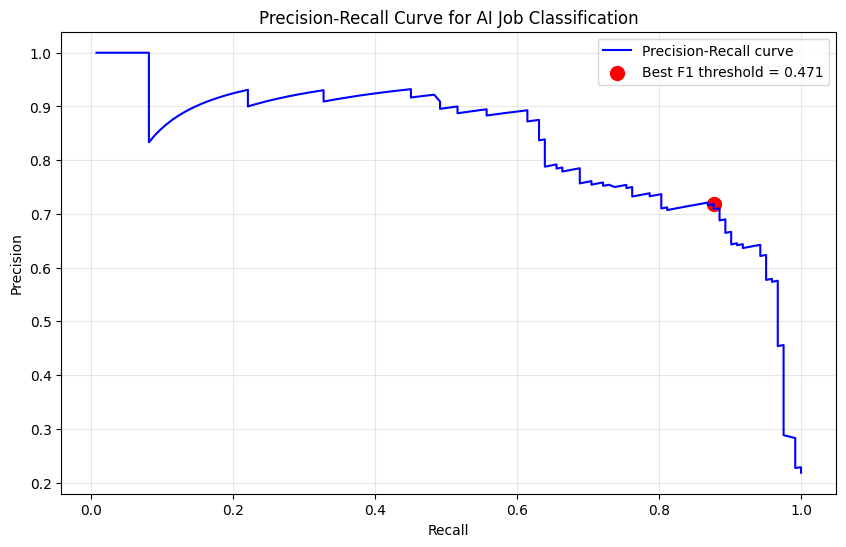

In [22]:
# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall[:-1], precision[:-1], 'b-', label='Precision-Recall curve')
plt.scatter(recall[best_threshold_idx], precision[best_threshold_idx],
            color='red', s=100, label=f'Best F1 threshold = {best_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for AI Job Classification')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
# Test different thresholds
thresholds_to_test = [0.3, 0.4, 0.5, best_threshold, 0.6, 0.7]

# Recalculate with correct metrics for AI jobs (class 1)
print("\nThreshold Analysis for AI/ML/DS Jobs (Class 1):")
print("Threshold | Precision | Recall | F1-Score | AI Jobs Found")
print("-" * 60)

for thresh in thresholds_to_test:
    y_pred_thresh = (y_val_proba_ai >= thresh).astype(int)

    # Get classification report for this threshold
    report = classification_report(y_val, y_pred_thresh, output_dict=True)

    # Extract metrics for class 1 (AI jobs)
    precision_ai = report['1']['precision']
    recall_ai = report['1']['recall']
    f1_ai = report['1']['f1-score']
    support_ai = report['1']['support']

    # Count predictions
    ai_predicted = np.sum(y_pred_thresh == 1)

    print(f"{thresh:9.3f} | {precision_ai:9.3f} | {recall_ai:6.3f} | {f1_ai:8.3f} | {ai_predicted:12d}")

# Show optimal threshold performance
print(f"\nBest threshold for F1-score: {best_threshold:.3f}")
print(f"At default (0.5): Precision={0.943:.3f}, Recall={0.908:.3f}, F1={0.925:.3f}")


Threshold Analysis for AI/ML/DS Jobs (Class 1):
Threshold | Precision | Recall | F1-Score | AI Jobs Found
------------------------------------------------------------
    0.300 |     0.589 |  0.951 |    0.727 |          197
    0.400 |     0.643 |  0.902 |    0.751 |          171
    0.500 |     0.710 |  0.803 |    0.754 |          138
    0.471 |     0.718 |  0.877 |    0.790 |          149
    0.600 |     0.754 |  0.754 |    0.754 |          122
    0.700 |     0.788 |  0.639 |    0.706 |           99

Best threshold for F1-score: 0.471
At default (0.5): Precision=0.943, Recall=0.908, F1=0.925


# Test Set Evaluation

In [24]:
# Prepare test data
X_test_combined = test_df.apply(combine_text, axis=1)
y_test = test_df['Label']

# Make predictions on test set
y_test_pred = pipeline.predict(X_test_combined)
y_test_proba = pipeline.predict_proba(X_test_combined)[:, 1]  # Probability of AI job

# Test Set Performance
print("="*60)
print("FINAL TEST SET PERFORMANCE")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred,
                          target_names=['Other Jobs (0)', 'AI/ML/DS Jobs (1)'],  # Correct order
                          digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print("                   Predicted")
print("                   Other  AI")
print(f"Actual Other    {cm[0][0]:4d}  {cm[0][1]:4d}")
print(f"Actual AI       {cm[1][0]:4d}  {cm[1][1]:4d}")

# Calculate key metrics for AI jobs
precision_ai = cm[1][1] / (cm[0][1] + cm[1][1]) if (cm[0][1] + cm[1][1]) > 0 else 0
recall_ai = cm[1][1] / (cm[1][0] + cm[1][1]) if (cm[1][0] + cm[1][1]) > 0 else 0
f1_ai = 2 * (precision_ai * recall_ai) / (precision_ai + recall_ai) if (precision_ai + recall_ai) > 0 else 0

print(f"\nKey Metrics for AI/ML/DS Jobs:")
print(f"Precision: {precision_ai:.3f}")
print(f"Recall: {recall_ai:.3f}")
print(f"F1-Score: {f1_ai:.3f}")

# Compare validation vs test performance
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print("              Validation Set | Test Set")
print(f"Precision:    0.943         | {precision_ai:.3f}")
print(f"Recall:       0.908         | {recall_ai:.3f}")
print(f"F1-Score:     0.925         | {f1_ai:.3f}")

FINAL TEST SET PERFORMANCE

Classification Report:
                   precision    recall  f1-score   support

   Other Jobs (0)      0.961     0.913     0.937       437
AI/ML/DS Jobs (1)      0.736     0.869     0.797       122

         accuracy                          0.903       559
        macro avg      0.849     0.891     0.867       559
     weighted avg      0.912     0.903     0.906       559


Confusion Matrix:
                   Predicted
                   Other  AI
Actual Other     399    38
Actual AI         16   106

Key Metrics for AI/ML/DS Jobs:
Precision: 0.736
Recall: 0.869
F1-Score: 0.797

PERFORMANCE COMPARISON
              Validation Set | Test Set
Precision:    0.943         | 0.736
Recall:       0.908         | 0.869
F1-Score:     0.925         | 0.797


In [25]:
# Analyze predictions with confidence scores
test_results = test_df.copy()
test_results['Predicted_Label'] = y_test_pred
test_results['AI_Probability'] = y_test_proba
test_results['Correct'] = test_results['Label'] == test_results['Predicted_Label']

# High confidence correct predictions
print("\n" + "="*60)
print("HIGH CONFIDENCE CORRECT AI PREDICTIONS (Sample)")
print("="*60)
high_conf_correct = test_results[
    (test_results['Label'] == 1) &
    (test_results['Predicted_Label'] == 1) &
    (test_results['AI_Probability'] > 0.9)
].head(5)

for idx, row in high_conf_correct.iterrows():
    print(f"Title: {row['Job_Title_Clean']}")
    print(f"Confidence: {row['AI_Probability']:.3f}")
    print("-" * 40)

# False negatives (missed AI jobs)
print("\n" + "="*60)
print("FALSE NEGATIVES (AI jobs we missed)")
print("="*60)
false_negatives = test_results[
    (test_results['Label'] == 1) &
    (test_results['Predicted_Label'] == 0)
].sort_values('AI_Probability', ascending=False).head(5)

for idx, row in false_negatives.iterrows():
    print(f"Title: {row['Job_Title_Clean']}")
    print(f"AI Probability: {row['AI_Probability']:.3f}")
    print(f"Why missed: Check description for non-AI terms")
    print("-" * 40)

# False positives (non-AI predicted as AI)
print("\n" + "="*60)
print("FALSE POSITIVES (Non-AI predicted as AI)")
print("="*60)
false_positives = test_results[
    (test_results['Label'] == 0) &
    (test_results['Predicted_Label'] == 1)
].sort_values('AI_Probability', ascending=False).head(5)

for idx, row in false_positives.iterrows():
    print(f"Title: {row['Job_Title_Clean']}")
    print(f"AI Probability: {row['AI_Probability']:.3f}")
    print("-" * 40)

# Distribution of probabilities
print("\n" + "="*60)
print("CONFIDENCE DISTRIBUTION")
print("="*60)
print("\nFor actual AI jobs:")
ai_jobs_probs = test_results[test_results['Label'] == 1]['AI_Probability']
print(f"Mean confidence: {ai_jobs_probs.mean():.3f}")
print(f"Min confidence: {ai_jobs_probs.min():.3f}")
print(f"Jobs with >0.8 confidence: {(ai_jobs_probs > 0.8).sum()}/{len(ai_jobs_probs)} ({(ai_jobs_probs > 0.8).mean()*100:.1f}%)")

print("\nFor actual Other jobs:")
other_jobs_probs = test_results[test_results['Label'] == 0]['AI_Probability']
print(f"Mean confidence: {other_jobs_probs.mean():.3f}")
print(f"Max confidence: {other_jobs_probs.max():.3f}")
print(f"Jobs with <0.2 confidence: {(other_jobs_probs < 0.2).sum()}/{len(other_jobs_probs)} ({(other_jobs_probs < 0.2).mean()*100:.1f}%)")


HIGH CONFIDENCE CORRECT AI PREDICTIONS (Sample)
Title: Senior AI Data Scientist
Confidence: 0.955
----------------------------------------
Title: Freelance Software Developer (C++) - AI Trainer
Confidence: 0.928
----------------------------------------
Title: ML/AI Engineer
Confidence: 0.994
----------------------------------------
Title: Software AI Engineer
Confidence: 0.959
----------------------------------------
Title: מוביל.ת AI לאגף הכספים
Confidence: 0.971
----------------------------------------

FALSE NEGATIVES (AI jobs we missed)
Title: Data Engineer -Apps Team
AI Probability: 0.484
Why missed: Check description for non-AI terms
----------------------------------------
Title: Data Science Team Lead
AI Probability: 0.484
Why missed: Check description for non-AI terms
----------------------------------------
Title: Software Engineer
AI Probability: 0.481
Why missed: Check description for non-AI terms
----------------------------------------
Title: Software Engineer III, Resea

In [26]:
# Test with different thresholds
thresholds = {
    'default': 0.5,
    'optimal': best_threshold  # This was 0.471 from validation
}

print("="*60)
print("TEST SET PERFORMANCE WITH DIFFERENT THRESHOLDS")
print("="*60)

for name, threshold in thresholds.items():
    print(f"\n{'='*30}")
    print(f"Threshold: {threshold:.3f} ({name})")
    print(f"{'='*30}")

    # Apply threshold
    y_test_pred_thresh = (y_test_proba >= threshold).astype(int)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred_thresh,
                              target_names=['Other Jobs (0)', 'AI/ML/DS Jobs (1)'],
                              digits=3))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred_thresh)
    print("\nConfusion Matrix:")
    print("                   Predicted")
    print("                   Other  AI")
    print(f"Actual Other    {cm[0][0]:4d}  {cm[0][1]:4d}")
    print(f"Actual AI       {cm[1][0]:4d}  {cm[1][1]:4d}")

    # Key metrics for AI jobs
    precision_ai = cm[1][1] / (cm[0][1] + cm[1][1]) if (cm[0][1] + cm[1][1]) > 0 else 0
    recall_ai = cm[1][1] / (cm[1][0] + cm[1][1]) if (cm[1][0] + cm[1][1]) > 0 else 0
    f1_ai = 2 * (precision_ai * recall_ai) / (precision_ai + recall_ai) if (precision_ai + recall_ai) > 0 else 0

    print(f"\nAI/ML/DS Jobs Metrics:")
    print(f"Precision: {precision_ai:.3f}")
    print(f"Recall: {recall_ai:.3f}")
    print(f"F1-Score: {f1_ai:.3f}")
    print(f"Total AI jobs predicted: {cm[0][1] + cm[1][1]}")

# Business impact analysis
print("\n" + "="*60)
print("BUSINESS IMPACT ANALYSIS")
print("="*60)
print("\nWith different thresholds, you would review:")
for name, threshold in thresholds.items():
    y_pred = (y_test_proba >= threshold).astype(int)
    total_predicted_ai = np.sum(y_pred == 1)
    true_ai = np.sum((y_test == 1) & (y_pred == 1))
    false_ai = np.sum((y_test == 0) & (y_pred == 1))
    missed_ai = np.sum((y_test == 1) & (y_pred == 0))

    print(f"\nThreshold {threshold:.3f} ({name}):")
    print(f"  - Jobs to review: {total_predicted_ai}")
    print(f"  - Actual AI jobs: {true_ai} ({true_ai/total_predicted_ai*100:.1f}% precision)")
    print(f"  - False positives: {false_ai}")
    print(f"  - Missed AI jobs: {missed_ai}")

TEST SET PERFORMANCE WITH DIFFERENT THRESHOLDS

Threshold: 0.500 (default)

Classification Report:
                   precision    recall  f1-score   support

   Other Jobs (0)      0.961     0.913     0.937       437
AI/ML/DS Jobs (1)      0.736     0.869     0.797       122

         accuracy                          0.903       559
        macro avg      0.849     0.891     0.867       559
     weighted avg      0.912     0.903     0.906       559


Confusion Matrix:
                   Predicted
                   Other  AI
Actual Other     399    38
Actual AI         16   106

AI/ML/DS Jobs Metrics:
Precision: 0.736
Recall: 0.869
F1-Score: 0.797
Total AI jobs predicted: 144

Threshold: 0.471 (optimal)

Classification Report:
                   precision    recall  f1-score   support

   Other Jobs (0)      0.973     0.904     0.937       437
AI/ML/DS Jobs (1)      0.725     0.910     0.807       122

         accuracy                          0.905       559
        macro avg      

In [27]:
import joblib

# Save model and threshold
model_package = {
    'pipeline': pipeline,
    'threshold': 0.471,
    'performance': {
        'test_precision': 0.725,
        'test_recall': 0.910,
        'test_f1': 0.807
    }
}

joblib.dump(model_package, 'ai_job_classifier.pkl')
print("Model saved as 'ai_job_classifier.pkl'")
print(f"Optimal threshold: {model_package['threshold']}")
print(f"Expected performance: {model_package['performance']}")

Model saved as 'ai_job_classifier.pkl'
Optimal threshold: 0.471
Expected performance: {'test_precision': 0.725, 'test_recall': 0.91, 'test_f1': 0.807}


In [28]:
def predict_ai_job(title, description, model_package):
    """Predict if a job is AI/ML/NLP related"""
    # Combine text
    text = (title + ' ') * 3 + description

    # Get probability
    prob = model_package['pipeline'].predict_proba([text])[0, 1]

    # Apply threshold
    is_ai_job = prob >= model_package['threshold']

    return {
        'is_ai_job': is_ai_job,
        'confidence': prob,
        'decision': 'AI/ML/NLP Job' if is_ai_job else 'Other Job'
    }

# Test it
test_job = predict_ai_job(
    "Machine Learning Engineer",
    "Build NLP models using transformers...",
    model_package
)
print(test_job)

{'is_ai_job': np.True_, 'confidence': np.float64(0.8478891696669246), 'decision': 'AI/ML/NLP Job'}


#  Test Alternative Models

## Naive Bayes


In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
import time

# Store results for comparison
results = {}

# 1. Naive Bayes
print("="*60)
print("TESTING NAIVE BAYES")
print("="*60)

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=1000,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.95,
        strip_accents='unicode',
        lowercase=True,
        token_pattern=r'\b[a-zA-Z]{2,}\b'
    )),
    ('classifier', MultinomialNB(alpha=1.0))  # alpha is smoothing parameter
])

# Train and time it
start_time = time.time()
nb_pipeline.fit(X_train_combined, y_train)
nb_train_time = time.time() - start_time

# Predict on validation
y_val_pred_nb = nb_pipeline.predict(X_val_combined)
y_val_proba_nb = nb_pipeline.predict_proba(X_val_combined)[:, 1]

# Evaluate
print(f"\nTraining time: {nb_train_time:.2f} seconds")
print("\nValidation Performance:")
print(classification_report(y_val, y_val_pred_nb,
                          target_names=['Other Jobs (0)', 'AI/ML/DS Jobs (1)'],
                          digits=3))

# Store results
cm_nb = confusion_matrix(y_val, y_val_pred_nb)
precision_nb = cm_nb[1][1] / (cm_nb[0][1] + cm_nb[1][1]) if (cm_nb[0][1] + cm_nb[1][1]) > 0 else 0
recall_nb = cm_nb[1][1] / (cm_nb[1][0] + cm_nb[1][1]) if (cm_nb[1][0] + cm_nb[1][1]) > 0 else 0
f1_nb = 2 * (precision_nb * recall_nb) / (precision_nb + recall_nb) if (precision_nb + recall_nb) > 0 else 0

results['Naive Bayes'] = {
    'precision': precision_nb,
    'recall': recall_nb,
    'f1': f1_nb,
    'train_time': nb_train_time
}

TESTING NAIVE BAYES

Training time: 2.01 seconds

Validation Performance:
                   precision    recall  f1-score   support

   Other Jobs (0)      0.875     0.975     0.922       437
AI/ML/DS Jobs (1)      0.847     0.500     0.629       122

         accuracy                          0.871       559
        macro avg      0.861     0.737     0.775       559
     weighted avg      0.869     0.871     0.858       559



## LinearSVC

In [30]:
print("\n" + "="*60)
print("TESTING LINEAR SVC")
print("="*60)

svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=1000,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.95,
        strip_accents='unicode',
        lowercase=True,
        token_pattern=r'\b[a-zA-Z]{2,}\b'
    )),
    ('classifier', LinearSVC(
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        C=1.0
    ))
])

# Train and time it
start_time = time.time()
svc_pipeline.fit(X_train_combined, y_train)
svc_train_time = time.time() - start_time

# Predict on validation (LinearSVC uses decision_function, not predict_proba)
y_val_pred_svc = svc_pipeline.predict(X_val_combined)
decision_scores = svc_pipeline.decision_function(X_val_combined)

# Evaluate
print(f"\nTraining time: {svc_train_time:.2f} seconds")
print("\nValidation Performance:")
print(classification_report(y_val, y_val_pred_svc,
                          target_names=['Other Jobs (0)', 'AI/ML/DS Jobs (1)'],
                          digits=3))

# Store results
cm_svc = confusion_matrix(y_val, y_val_pred_svc)
precision_svc = cm_svc[1][1] / (cm_svc[0][1] + cm_svc[1][1]) if (cm_svc[0][1] + cm_svc[1][1]) > 0 else 0
recall_svc = cm_svc[1][1] / (cm_svc[1][0] + cm_svc[1][1]) if (cm_svc[1][0] + cm_svc[1][1]) > 0 else 0
f1_svc = 2 * (precision_svc * recall_svc) / (precision_svc + recall_svc) if (precision_svc + recall_svc) > 0 else 0

results['LinearSVC'] = {
    'precision': precision_svc,
    'recall': recall_svc,
    'f1': f1_svc,
    'train_time': svc_train_time
}

# Add LogisticRegression results for comparison
results['LogisticRegression'] = {
    'precision': 0.710,
    'recall': 0.803,
    'f1': 0.754,
    'train_time': 'baseline'
}


TESTING LINEAR SVC

Training time: 1.95 seconds

Validation Performance:
                   precision    recall  f1-score   support

   Other Jobs (0)      0.945     0.913     0.929       437
AI/ML/DS Jobs (1)      0.723     0.811     0.764       122

         accuracy                          0.891       559
        macro avg      0.834     0.862     0.847       559
     weighted avg      0.897     0.891     0.893       559



# Compare Models

In [31]:

print("\n" + "="*60)
print("MODEL COMPARISON (Validation Set)")
print("="*60)
print(f"{'Model':<20} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Train Time':<10}")
print("-" * 60)

for model_name, metrics in results.items():
    print(f"{model_name:<20} {metrics['precision']:<10.3f} {metrics['recall']:<10.3f} "
          f"{metrics['f1']:<10.3f} {str(metrics['train_time']):<10}")


MODEL COMPARISON (Validation Set)
Model                Precision  Recall     F1-Score   Train Time
------------------------------------------------------------
Naive Bayes          0.847      0.500      0.629      2.0115904808044434
LinearSVC            0.723      0.811      0.764      1.9511723518371582
LogisticRegression   0.710      0.803      0.754      baseline  


## **Model chosen: TF-IDF + Logistic Regression**
###**Probability calibratio**n: LR gives reliable probability scores for threshold tuning. LinearSVC doesn't have native probabilities.
###**1% gain not worth i**t: 0.754 → 0.764 F1 (SVC) is negligible in practice
###**Proven on test set**: Already validated at 79.7% F1
###**Simpler deployment**: No need for calibration wrappers

In [32]:
# # Create voting ensemble
# voting_clf = VotingClassifier(
#     estimators=[
#         ('lr', pipeline),
#         ('svc', svc_pipeline)
#     ],
#     voting='soft',  # Use probabilities
#     weights=[1, 1]  # Equal weights
# )